In [2]:
import os 
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random 
from PIL import Image, ImageDraw
from collections import Counter

import torch
import torchvision
import torch.optim as optim
from torchvision import transforms as T
from torchvision.transforms import functional as F
from torch.optim.lr_scheduler import MultiStepLR
from torchvision.models.detection import FasterRCNN
from torchvision.utils import draw_bounding_boxes
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
class CustomObjectDetectionDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_excel(csv_file)
        # self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # img_name = os.path.join(self.root_dir, self.data.iloc[idx, 1]+ "/" + self.data.iloc[idx, 0])
        img_name = os.path.join(self.data.iloc[idx, 6])
        image = Image.open(img_name)

        # Extract bounding box coordinates and labels
        x1 = self.data.iloc[idx, 2]
        y1 = self.data.iloc[idx, 3]
        w = self.data.iloc[idx, 4]
        h = self.data.iloc[idx, 5]
        boxes = [x1, y1, x1 + w, y1 + h]
        labels = self.data.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, {
            "boxes": boxes,  # [x1, y1, x2, y2]
            "labels": labels
        }

In [4]:
img_path = "ExDark/ExDark/"

train_csv_path = "exdark_train.xlsx"
valid_csv_path = "exdark_validation.xlsx"
test_csv_path = "exdark_test.xlsx"

data_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomObjectDetectionDataset(csv_file=train_csv_path, transform=data_transform)
valid_dataset = CustomObjectDetectionDataset(csv_file=valid_csv_path, transform=data_transform)
test_dataset = CustomObjectDetectionDataset(csv_file=test_csv_path, transform=data_transform)

batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

FileNotFoundError: [Errno 2] No such file or directory: 'exdark_train.xlsx'

In [ ]:
train_dataset.__getitem__(0)

(tensor([[[0.3255, 0.4510, 0.4157,  ..., 0.3373, 0.3333, 0.3333],
          [0.2902, 0.4353, 0.4353,  ..., 0.3373, 0.3373, 0.3373],
          [0.3059, 0.4235, 0.4706,  ..., 0.3333, 0.3333, 0.3333],
          ...,
          [0.0706, 0.0863, 0.0784,  ..., 0.1020, 0.0784, 0.0745],
          [0.0863, 0.0902, 0.0902,  ..., 0.0941, 0.0902, 0.0824],
          [0.0902, 0.0745, 0.0941,  ..., 0.0941, 0.0824, 0.0824]],
 
         [[0.2863, 0.4392, 0.4431,  ..., 0.2706, 0.2667, 0.2667],
          [0.2980, 0.4314, 0.4431,  ..., 0.2824, 0.2824, 0.2824],
          [0.2824, 0.4118, 0.4667,  ..., 0.2745, 0.2745, 0.2745],
          ...,
          [0.0706, 0.0863, 0.0784,  ..., 0.0314, 0.0314, 0.0353],
          [0.0863, 0.0902, 0.0902,  ..., 0.0314, 0.0353, 0.0353],
          [0.0902, 0.0745, 0.0941,  ..., 0.0314, 0.0275, 0.0275]],
 
         [[0.2392, 0.3647, 0.3216,  ..., 0.2000, 0.1961, 0.1961],
          [0.2157, 0.3529, 0.3490,  ..., 0.1765, 0.1765, 0.1686],
          [0.2275, 0.3451, 0.3843,  ...,

In [ ]:
class_names = np.unique(train_dataset.data.iloc[:, 1])
print(class_names)

['Bicycle' 'Boat' 'Bottle' 'Bus' 'Car' 'Cat' 'Chair' 'Cup' 'Dog'
 'Motorbike' 'People' 'Table']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


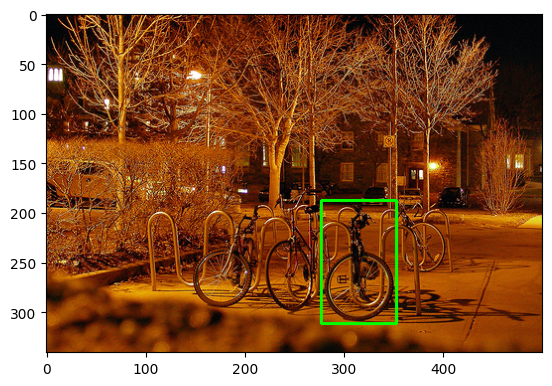

In [ ]:
sample = train_dataset[3]

image = np.array(sample[0].permute(1, 2, 0))
x1, y1, x2, y2 = sample[1]["boxes"]

# Create a copy of the image
img_bbox = image.copy()

# Draw the rectangle on the copy
cv2.rectangle(img_bbox, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the image with the rectangle
plt.imshow(img_bbox)
plt.show()


In [ ]:
images, targets = next(iter(train_dataloader))

In [ ]:
# Load a pre-trained backbone
backbone = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the number of classes in the model
num_classes = len(class_names)  # Change this to the number of classes in your dataset
in_features = backbone.roi_heads.box_predictor.cls_score.in_features
backbone.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

backbone.out_channels = 2048

d:\Anaconda\envs\CUDA1\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\envs\CUDA1\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from torchvision.models.detection.rpn import AnchorGenerator

rpn_anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
model = FasterRCNN(backbone, num_classes=num_classes, rpn_anchor_generator=rpn_anchor_generator, box_roi_pool=None)

# Define an optimizer
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Define a learning rate scheduler (adjust the milestones as needed)
lr_scheduler = MultiStepLR(optimizer, milestones=[8, 11], gamma=0.1)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 

In [ ]:
for epoch in range(10):  # Change the number of epochs as needed
    model.train()
    for images, targets in train_dataloader:
        # images = [img for img in images]
        targets = [{k: v for k, v in targets.items()}]
        
        # Convert target boxes to tensors
        for target in targets:
            if len(target["boxes"]) == 0:
                print(target["boxes"])
    #         target["boxes"] = torch.tensor(target["boxes"], dtype=torch.float32)
    #         target["labels"] = torch.tensor(target["labels"], dtype=torch.int64)
        
    #     loss_dict = model(images, targets)
    #     losses = sum(loss for loss in loss_dict.values())
        
    #     optimizer.zero_grad()
    #     losses.backward()
    #     optimizer.step()

    # lr_scheduler.step()

KeyboardInterrupt: 

In [ ]:
num_epochs = 5
for epoch in range(num_epochs):
    epoch_loss = 0 
    for data in train_dataloader:
        imgs = []
        targets = []
        for d in data:
            imgs.append(d[0].to(device))
            targ = {}
            targ["boxes"] = d[1]["boxes"].to(device)
            targ["labels"] = d[1]["labels"].to(device)
            targets.append(targ)
        loss_dict = model(imgs, targets)
        loss = sum(v for v in loss_dict.values())
        epoch_loss += loss.cpu().detach().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(epoch_loss)

IndexError: too many indices for tensor of dimension 3

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    for images, targets in train_dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    # Update learning rate
    lr_scheduler.step()

    # Print training information (customize as needed)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {losses.item()}")

AttributeError: 'str' object has no attribute 'items'

In [ ]:
for images, targets in train_dataloader:
    print(images.shape, len(targets))

torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2
torch.Size([4, 3, 224, 224]) 2


RuntimeError: stack expects each tensor to be equal size, but got [1, 224, 224] at entry 0 and [3, 224, 224] at entry 1